{'Long Task': [(0, 10), (10, 11), (11, 21), (21, 23), (23, 33), (33, 35), (35, 45), (45, 46), (47, 56), (56, 58), (58, 68), (68, 70), (70, 80), (80, 82), (82, 92), (92, 93), (94, 103), (103, 105)], 'Short Task': [(10, 10), (11, 11), (21, 21), (23, 23), (33, 33), (35, 35), (45, 45), (46, 46), (56, 56), (58, 58), (68, 68), (70, 70), (80, 80), (82, 82), (92, 92), (93, 93), (103, 103), (105, 105)]}


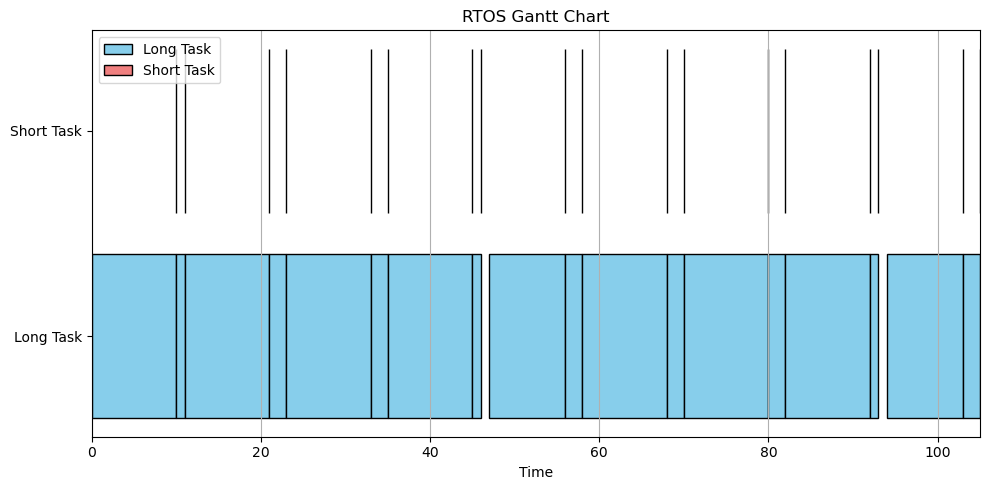

In [ ]:
import re
import matplotlib.pyplot as plt

# --- Step 1: Parse the log for events ---
events = []

# Get data from sample_data.txt
with open('sample_data.txt', 'r') as f:
    for line in f:
        line = line.strip()
        # Match start events
        start_long = re.match(r'Long task started\. Time: (\d+)', line)
        # search b/c interrupt might run in the middle of another print
        interrupt_long = re.search(r'Interrupt handler running\. Time: (\d+)', line)
        resume_long = re.match(r'Long task resumed\. Time: (\d+)', line)
        start_short = re.match(r'Short task started\. Time: (\d+)', line)
        complete_short = re.match(r'Short task completed\. Time: (\d+)', line)
        finish_long = re.match(r'Long task finished\. Time: (\d+)', line)

        if start_long:
            events.append({'task': 'Long Task', 'action': 'start', 'time': int(start_long.group(1))})
        elif interrupt_long:
            events.append({'task': 'Long Task', 'action': 'end', 'time': int(interrupt_long.group(1))})
        elif resume_long:
            events.append({'task': 'Long Task', 'action': 'start', 'time': int(resume_long.group(1))})
        elif start_short:
            events.append({'task': 'Short Task', 'action': 'start', 'time': int(start_short.group(1))})
        elif complete_short:
            events.append({'task': 'Short Task', 'action': 'end', 'time': int(complete_short.group(1))})
        elif finish_long:
            events.append({'task': 'Long Task', 'action': 'end', 'time': int(finish_long.group(1))})

# --- Step 2: Group into task durations ---
# We will track currently running tasks
task_times = {'Long Task': [], 'Short Task': []}
running_tasks = {}

for event in events:
    task = event['task']
    action = event['action']
    time = event['time']

    if action == 'start':
        running_tasks[task] = time
    elif action == 'end':
        if task in running_tasks:
            start_time = running_tasks.pop(task)
            task_times[task].append((start_time, time))

print(task_times)

# --- Step 3: Plot using matplotlib ---
fig, ax = plt.subplots(figsize=(10, 5))

colors = {'Long Task': 'skyblue', 'Short Task': 'lightcoral'}

y_pos = {'Long Task': 0, 'Short Task': 1}

for task, periods in task_times.items():
    for start, end in periods:
        ax.barh(y_pos[task], end - start, left=start, color=colors[task], edgecolor='black', label=task)

# Make sure legend doesn't repeat
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_yticks([y_pos['Long Task'], y_pos['Short Task']])
ax.set_yticklabels(['Long Task', 'Short Task'])
ax.set_xlabel('Time')
ax.set_title('RTOS Gantt Chart')
ax.grid(True, axis='x')

plt.tight_layout()
plt.show()
